In [1]:
%matplotlib inline
from IPython import display

import itertools
import math
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms

In [2]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_dataset = datasets.MNIST(root="./data",
                              train=True,
                              download=True,
                              transform=transform)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

Processing...
Done!


In [3]:
class Discriminator(nn.Module):
    def __init__(self, in_size=1, ndf=128):
        super(Discriminator, self).__init__()
        self.in_size = in_size
        self.ndf = ndf
        
        self.main = nn.Sequential(
            nn.Conv2d(self.in_size, self.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf, self.ndf *2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf * 4, self.ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
                if m.bias is not None:
                    m.bias.data.zero_()
                    
    def forward(self, x):
        h = self.main(x)
        return h

In [4]:
class Generator(nn.Module):
    def __init__(self, z_size=100, out_size=1, ngf=128):
        super(Generator, self).__init__()
        self.z_size = z_size
        self.ngf = ngf
        self.out_size = out_size
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(self.z_size, self.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(self.ngf * 2, self.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(self.ngf, self.out_size, 4, 2, 1, bias=False),
            nn.Tanh(),
        )
        
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0.0, 0.02)
                if m.bias is not None:
                    m.bias.data.zero_()
                    
    def forward(self, x):
        h = self.main(x)
        return h

In [14]:
dis = Discriminator().cuda()
gen = Generator().cuda()

In [15]:
criterion = nn.BCELoss()
lr = 0.0002
d_optimizer = torch.optim.Adam(dis.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(gen.parameters(), lr=lr)

In [16]:
def train_discriminator(dis, x_real, y_real, x_fake, y_fake):
    dis.zero_grad()
    
    outputs = dis(x_real)
    real_loss = criterion(outputs, y_real)
    real_score = outputs
    
    outputs = dis(x_fake)
    fake_loss = criterion(outputs, y_fake)
    fake_score = outputs
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [17]:
def train_generator(gen, dis_outputs, y_real):
    gen.zero_grad()
    g_loss = criterion(dis_outputs, y_real)
    g_loss.backward()
    g_optimizer.step()
    
    return g_loss

In [24]:
num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, 100)).view(-1, 100, 1, 1).cuda()

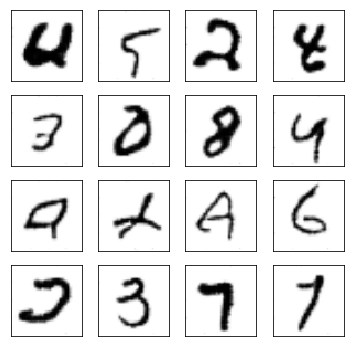

Epoch [24/200], Step[600/600], d_loss: 0.0172, g_loss: 3.7585, D(x): 1.00, D(G(z)): 0.01


In [ ]:
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i, j].get_xaxis().set_visible(False)
    ax[i, j].get_yaxis().set_visible(False)
    
num_epochs = 200
num_batches = len(train_loader)
num_fig = 0

for epoch in range(num_epochs):
    for n, (images, _) in enumerate(train_loader):
        images = Variable(images).cuda()
        y_real = Variable(torch.ones(images.size(0))).cuda()
        
        z = Variable(torch.randn(images.size(0), 100)).view(-1, 100, 1, 1).cuda()
        x_fake = gen(z)
        y_fake = Variable(torch.zeros(images.size(0),)).cuda()
        
        d_loss, real_score, fake_score = train_discriminator(dis, images, y_real, x_fake, y_fake)
        
        z = Variable(torch.randn(images.size(0), 100)).view(-1, 100, 1, 1).cuda()
        x_fake = gen(z)
        outputs = dis(x_fake)
        
        g_loss = train_generator(gen, outputs, y_real)
        
        if (n+1) % 100 == 0:
            test_images = gen(test_noise)
            for k in range(num_test_samples):
                i = k // 4
                j = k % 4
                ax[i, j].cla()
                ax[i, j].imshow(test_images[k, :].cpu().data.numpy().reshape(64, 64), cmap="Greys")
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            plt.savefig("results/%03d.png" % num_fig)
            num_fig += 1
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
                  'D(x): %.2f, D(G(z)): %.2f' 
                  %(epoch + 1, num_epochs, n+1, num_batches, d_loss.data[0], g_loss.data[0],
                    real_score.data.mean(), fake_score.data.mean()))

fig.close()

### 